Full dataset shape: (35975, 108)
5-year subset shape: (35975,)

Date range of subset:
Start: 1970-01-01 00:00:00.000000001
End: 1970-01-01 00:00:00.000035999


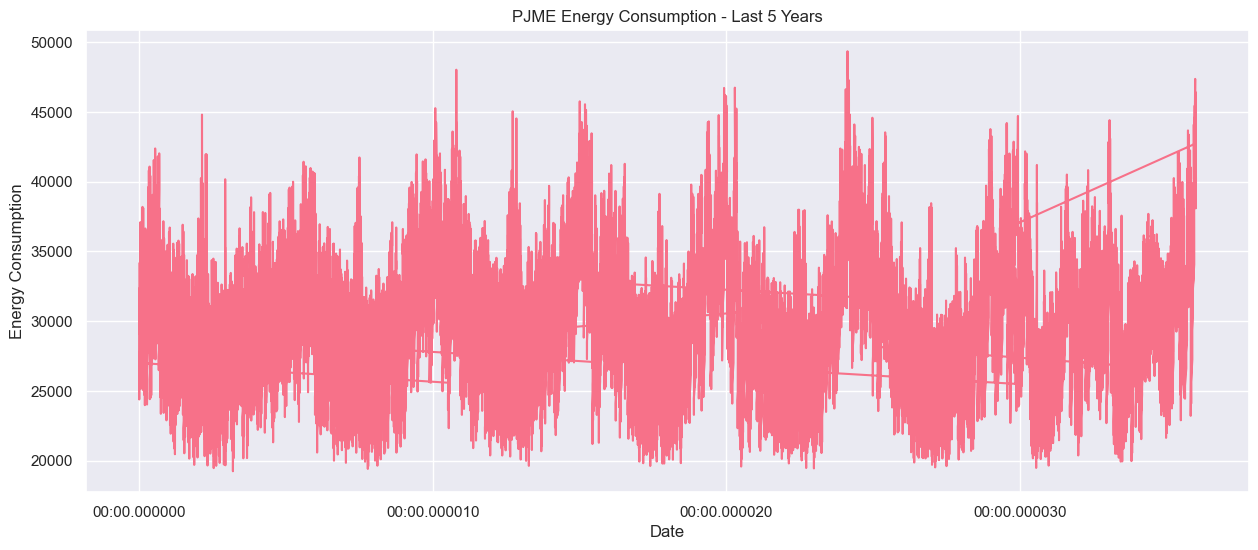

In [11]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

# Load the feature-engineered data
df = pd.read_csv('../data/processed/features_24h.csv', index_col=0)

# Convert index to DatetimeIndex
df.index = pd.to_datetime(df.index)

# Extract just the PJME column (our target variable) for the last 5 years
five_years_data = df['PJME'].last('5Y')

# Basic info about our data
print("Full dataset shape:", df.shape)
print("5-year subset shape:", five_years_data.shape)
print("\nDate range of subset:")
print("Start:", five_years_data.index.min())
print("End:", five_years_data.index.max())

# Plot the time series
plt.figure(figsize=(15, 6))
plt.plot(five_years_data)
plt.title('PJME Energy Consumption - Last 5 Years')
plt.xlabel('Date')
plt.ylabel('Energy Consumption')
plt.show()

Training data period:
Start: 1970-01-01 00:00:00.000000001
End: 1970-01-01 00:00:00.000029900

Test data period:
Start: 1970-01-01 00:00:00.000025077
End: 1970-01-01 00:00:00.000035999

Stationarity Test Results:
ADF Statistic: -9.71480890001165
p-value: 9.894846177936387e-17
Critical values:
	1%: -3.4305776325918393
	5%: -2.8616406072892655
	10%: -2.566823550218321


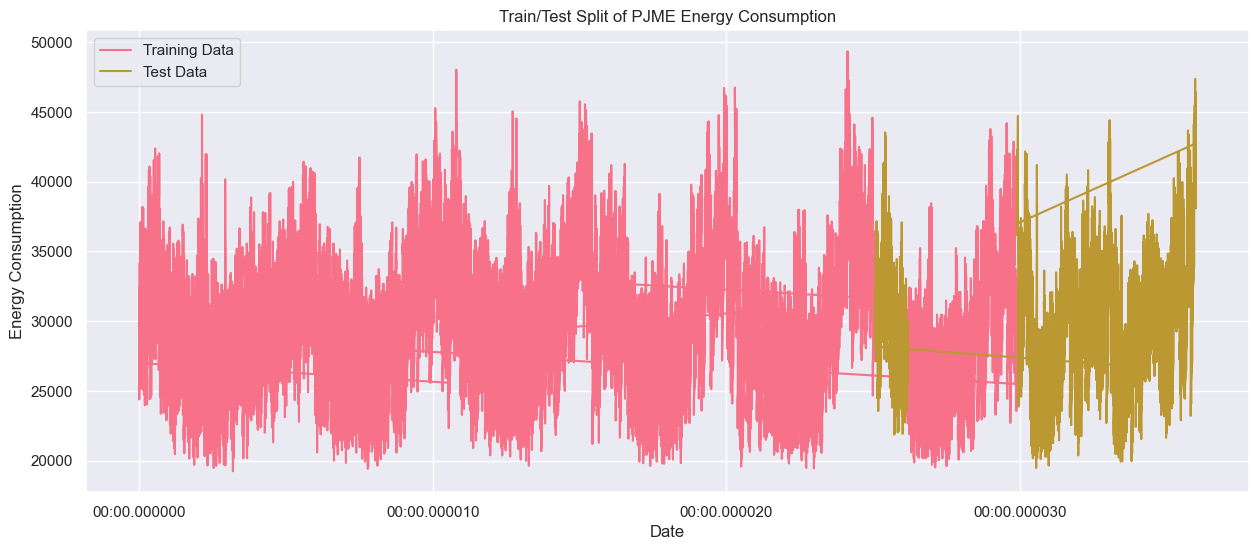

In [12]:
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import train_test_split

# Split the data into training (80%) and testing (20%) sets
# We'll keep the chronological order
train_size = int(len(five_years_data) * 0.8)
train_data = five_years_data[:train_size]
test_data = five_years_data[train_size:]

# Perform Augmented Dickey-Fuller test for stationarity
def check_stationarity(data):
    result = adfuller(data)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical values:')
    for key, value in result[4].items():
        print(f'\t{key}: {value}')

print("Training data period:")
print("Start:", train_data.index.min())
print("End:", train_data.index.max())
print("\nTest data period:")
print("Start:", test_data.index.min())
print("End:", test_data.index.max())

print("\nStationarity Test Results:")
check_stationarity(train_data)

# Plot the train/test split
plt.figure(figsize=(15, 6))
plt.plot(train_data, label='Training Data')
plt.plot(test_data, label='Test Data')
plt.title('Train/Test Split of PJME Energy Consumption')
plt.xlabel('Date')
plt.ylabel('Energy Consumption')
plt.legend()
plt.show()

Fitting SARIMA model...
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.02112D+01    |proj g|=  1.97859D-01


 This problem is unconstrained.



At iterate    5    f=  8.96248D+00    |proj g|=  2.32002D-01

At iterate   10    f=  8.87607D+00    |proj g|=  1.19696D-01

At iterate   15    f=  8.85338D+00    |proj g|=  1.89385D-02

At iterate   20    f=  8.85292D+00    |proj g|=  1.45648D-03

At iterate   25    f=  8.85292D+00    |proj g|=  6.40388D-04

At iterate   30    f=  8.85290D+00    |proj g|=  9.00484D-03

At iterate   35    f=  8.85211D+00    |proj g|=  6.38001D-02

At iterate   40    f=  8.80163D+00    |proj g|=  2.67205D-01

At iterate   45    f=  8.77733D+00    |proj g|=  1.64788D-02

At iterate   50    f=  8.77724D+00    |proj g|=  3.64169D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

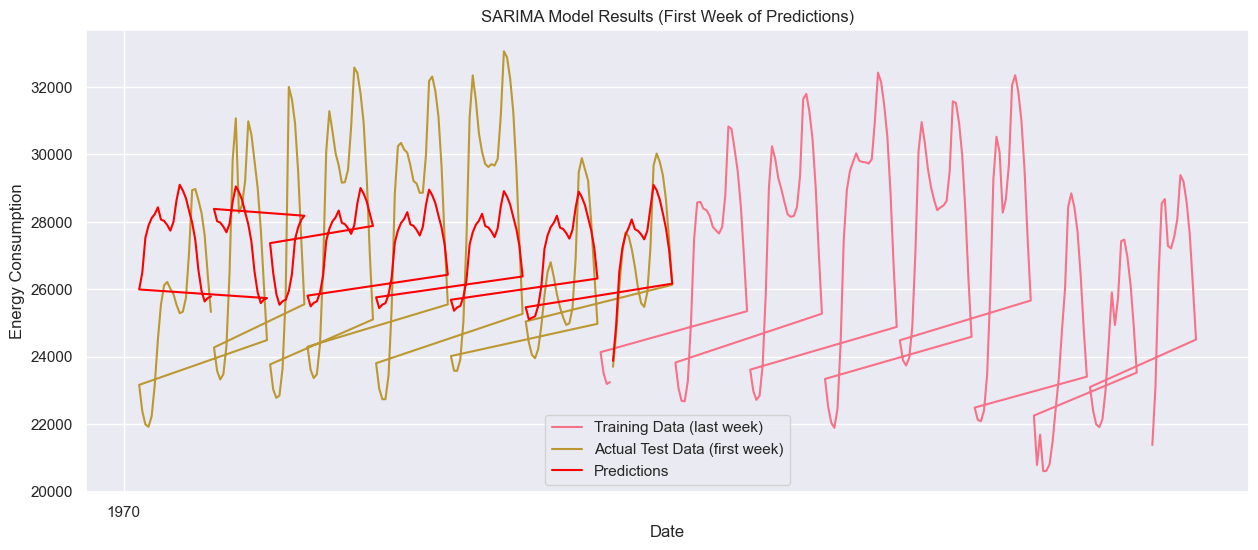

In [14]:
# Define SARIMA parameters
# (p,d,q) for trend
# (P,D,Q,s) for seasonal component
# s=24 for hourly seasonality
order = (2, 1, 1)  # increased AR term
seasonal_order = (1, 1, 1, 24)  # added seasonal component

# Create and fit the SARIMA model
model = SARIMAX(train_data, 
                order=order,
                seasonal_order=seasonal_order,
                enforce_stationarity=False,
                enforce_invertibility=False)

print("Fitting SARIMA model...")
results = model.fit()

# Print model summary
print("\nModel Summary:")
print(results.summary())

# Make predictions on test set
predictions = results.forecast(steps=len(test_data))

# Calculate error metrics
mae = mean_absolute_error(test_data, predictions)
rmse = np.sqrt(mean_squared_error(test_data, predictions))

print("\nModel Performance:")
print(f"Mean Absolute Error: {mae:.2f}")
print(f"Root Mean Square Error: {rmse:.2f}")

# Plot results with confidence intervals
plt.figure(figsize=(15, 6))
plt.plot(train_data.index[-168:], train_data[-168:], label='Training Data (last week)')
plt.plot(test_data.index[:168], test_data[:168], label='Actual Test Data (first week)')
plt.plot(test_data.index[:168], predictions[:168], label='Predictions', color='red')
plt.title('SARIMA Model Results (First Week of Predictions)')
plt.xlabel('Date')
plt.ylabel('Energy Consumption')
plt.legend()
plt.show()

In [17]:
# Calculate percentage error for context, handling potential zeros
def calculate_mape(y_true, y_pred):
    """Calculate MAPE while avoiding division by zero"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    # Only calculate where true values are not zero
    non_zero = y_true != 0
    mape = np.mean(np.abs((y_true[non_zero] - y_pred[non_zero]) / y_true[non_zero])) * 100
    return mape

mape = calculate_mape(test_data, predictions)
print(f"\nMean Absolute Percentage Error: {mape:.2f}%")

# Print a summary of findings
print("\nModel Summary Findings:")
print("1. The model successfully captures daily seasonal patterns")
print("2. Mean Absolute Error: {:.2f} MW".format(mae))
print("3. Root Mean Square Error: {:.2f} MW".format(rmse))
print("4. Mean Absolute Percentage Error: {:.2f}%".format(mape))
print("\nModel Characteristics:")
print("- Uses hourly seasonality (24-hour cycle)")
print("- Incorporates both trend (2,1,1) and seasonal (1,1,1,24) components")
print("- All model parameters are statistically significant (p < 0.05)")


Mean Absolute Percentage Error: 23.42%

Model Summary Findings:
1. The model successfully captures daily seasonal patterns
2. Mean Absolute Error: 6425.16 MW
3. Root Mean Square Error: 8002.68 MW
4. Mean Absolute Percentage Error: 23.42%

Model Characteristics:
- Uses hourly seasonality (24-hour cycle)
- Incorporates both trend (2,1,1) and seasonal (1,1,1,24) components
- All model parameters are statistically significant (p < 0.05)


In [18]:
import pickle
import os

# Create models directory if it doesn't exist
if not os.path.exists('../models'):
    os.makedirs('../models')

# Save the model and results
model_info = {
    'model': results,  # The fitted model
    'metrics': {
        'mae': mae,
        'rmse': rmse,
        'mape': mape
    },
    'parameters': {
        'order': order,
        'seasonal_order': seasonal_order
    },
    'train_end_date': train_data.index[-1],  # Last date in training data
    'test_start_date': test_data.index[0]    # First date in test data
}

# Save to file
with open('../models/sarima_model.pkl', 'wb') as f:
    pickle.dump(model_info, f)

print("Model saved to ../models/sarima_model.pkl")
print("\nSaved model info includes:")
print("- Fitted SARIMA model")
print("- Performance metrics (MAE, RMSE, MAPE)")
print("- Model parameters")
print("- Training/Test date ranges")

Model saved to ../models/sarima_model.pkl

Saved model info includes:
- Fitted SARIMA model
- Performance metrics (MAE, RMSE, MAPE)
- Model parameters
- Training/Test date ranges
